# SC42150 - Python assignment 2

Adaptive Noise Cancellation Applied to RF Communication



## Team members

Abina Boesjes 5094011

Thomas Nagy Zambo 5140196

## Introduction

This application follows the theory from Chapter 9. The goal of adaptive noise
cancellation is to remove interference from a signal of interest by means of a
correlated noise reference signal. In this example, we consider an RF communication system consisting of an
emitter and a receiver. These systems experience noise at the receiver that causes
signal degradation. The interference originates from the thermal noise of the system
and from the RF environment. The receiver measures signals of interest
on the main channel and reference noise on a secondary channel. Since both
channels have different propagation delays and distortions, the noise signals are
distinct. However, the unwanted noise in the primary port and the reference
noise are highly correlated. Therefore, it is possible to design a linear FIR filter
that produces an estimate of the interference from the primary channel. We wish
to use the theory of Wiener filters to recover the underlying audio signal.

## Reporting


The report of this python exercise consists of a PDF version of this Jupyter Notebook file, with your answers added after each question. Answers will consist of code and/or text (markdown) cells.
In order to create a PDF version of this file, go to the top left, click on `File` then `Download As` and Choose **PDF**.
If this feature is not supported by your system, you can also choose **LaTeX**.
Then, you can use your preferred **LaTeX** compiler to create the **PDF**. After generation you PDF report, please double check if all answers/plots are correctly displayed.

Moreover, you will also need to send the .mat file with the signals used in this exercise. Don't forget to edit your team member's name and student number above. You will submit one Jupyter notebook per team.

## First steps

Make sure that the files `Audio.py`, `Communication.py` and `anc.jpg` are included in the same directory as this Jupyter notebook. Run the following code:

In [13]:
! pip3 install pyserial
! pip3 install sounddevice
! pip3 install scipy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


**Note:** You only need to execute this code snippet once, after that your python will permanently include the modules. If the the code gives an error, manually install the modules using pip in the command prompt. In Windows: start button->search, type cmd->`pip install package_name`

## Question 1
Follow the instructions bellow in order to transmit/receive the signals that will be used in this assignment.

### Signal transmission

- Place a 32-bit .wav file in the same folder as this jupyter notebook (you can use the `piano.wav` or `gong.wav` files provided). Fill in the filename in the function `Audio.read_audiofile('filename.wav',length_seconds)` to load the audio;
- Set a desired duration for the transfer. It is recommended to start with signal lengths of one second to three, since serial transmission is a slow protocol;
- Connect the transceiver to a USB port. If the device is functioning properly, when instantiating the `Communication.Comm()` object you will get the following message: `Device recognized`;
- For signal transmission to take place, the receiving computer must be "listening" for signals. Make sure that the **receiver code snippet is running before executing sending**. When signal transmission starts, you will get a `started` message;
- It is suggested to start with short distances between the transmitter and the receiver, shorter than 1 meter. This will keep the SNR at acceptable levels.

### Signal acquisition

- There are two channels on the antenna of the dongles. The first listens for signals. The second channel measures adjacent noise from the environment which is correlated with the noise in the main channel. When you call `receiver.receive()`, you get two return values: the first one measures the signal from the emitters and the second measures a brown noise signal;
- When the signal is received, the program will display the message `done`.

### Receive Signal: run on receiving PC

In [2]:
# import Audio
# import Communication
# import numpy as np

# receiver = Communication.Comm()

# audio_sig, channelNoise_sig = receiver.receive()

### Send signal: run on sending PC

**Note**: Execute after the paired PC has executed the receiving code

In [3]:
# Load modules
# import Communication
# import Audio

# Instantiate communication object 
# transmit = Communication.Comm()

# Load audio 
# length_seconds = 5
# datasend = Audio.read_audiofile('gong.wav',length_seconds)

# Send
# transmit.write(datasend)  

**Troubleshooting:** if you have problems transmitting the signal, try disconnecting **both** devices and connecting them again. The ports may be overflowed with data after long periods of time or there may be a poor connection. If the problem persists, also try restarting the Jupyter notebook's kernel.

### Play the signal
Go to this section after you **received** a signal.
Play the audio, can you hear the signal through the noise? If you can't hear it at all, try to reduce the distance between the transmitter and receiver devices.

In [4]:
#import sounddevice as sim
# import sounddevice as sd

# function for playing a signal
# You can use it further if you want to listen smth

# def play_signal( signal ):
#     sd.play( signal.astype('int16'), 22050 )

In [5]:
# play_signal(audio_sig)

### Display signal and noise source

In [6]:
# import matplotlib.pyplot as plt
# t = np.arange(0.,  audio_sig.shape[0]/22050, 1/22050)
# plt.figure(figsize=(15, 5))
# plt.plot(t,audio_sig,'g', linewidth=0.7, label='raw audio')
# plt.plot(t,channelNoise_sig,'b', linewidth=0.7, label='correlated noise')
# plt.ylabel('PCM []')
# plt.xlabel('time [s]')
# plt.grid(True)

### Saving the signal with the noise as a .mat file
Run this section after you received and played a signal.
It will save the audio signals as a .mat file. With this file, you no longer need the RF comminication hardware to proceed with this assignment. Note that this is the .mat file you will need to hand-in together with the Jupyter notebook with your answers.

In [7]:
# saving the signals in .mat file
# import scipy.io as sciio

# sciio.savemat('audiodata.mat', mdict = {
#     'audio' : audio_sig,
#     'noise': channelNoise_sig,
# })

# print( f'number of points = {audio_sig.shape}' )

### Load the .mat file

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import sounddevice as sd
from scipy import signal
from scipy.linalg import toeplitz

# load the data file
data = sio.loadmat('audiodata.mat')  # contains data, (print to see)

# constants
N = len(data['audio'][0]) # number of data points per signal
x = np.arange(0, N)  # point indices
print(N)

21605


## Question 2

Formulate the problem as a Minimum Variance FIR Wiener Problem, using the symbols $v_1, \ v_2, \ y, \ \hat{v}_1, \ d,$ and $e$ as in the figure below. No numerical values are required in this part. It is sufficient to connect the theory to the practice by explaining the meaning of all the symbols and their relation to the two measured signals: *audio_sig* and *channelNoise_sig*. Also explain how to finally recover the interference-free audio signal when the Wiener problem has been solved. **(3 points)**

![alt text][anc]

[anc]: ./anc.JPG

### Answer 2

The goal of this problem is to estimate a target signal $d(n)$ by removing a noise $v_1(n)$ from a source $y(n)$ (*audio_sig*). 

To accomplish this, a Wiener filter is employed. The filter $W(z)$ processes a second source of noise $v_2(n)$ (*channelNoise_sig*) to create an approximation of $v_1(n)$, $\hat{v}_1(n)$. This Wiener filter is finite and of the form:

$$ \sum_{j=0}^{m-1} w\big(j\big) z^{-j} $$

An expression for the output of the filter is found through convolution:

$$ \hat{v}_1\big(n\big) = \sum_{j=0}^{m-1} w\big(j\big)v_2\big(n-j\big) $$

The resulting approximation $\hat{v}_1(n)$ is subtracted from the source $y(n)$ to create an estimation of the target signal $d(n)$. However, this process is not perfect and an error $e(n)$ is introduced. It is then desirable to choose the parameters of the Wiener filter $w(j)$ in such a way as to minimize this error. Mathematically this is expressed as:

$$ \min_{w(j)} E\Big[\big|e\big(n; w(j)\big)\big|^{2}\Big] $$

Using this optimal Wiener filter, the expression for the best possible approximation of the signal $d(n)$ becomes:

$$ \hat{d}(n) = y(n) - \sum_{j=0}^{m-1} w\big(j\big)v_2\big(n-j\big) $$


## Question 3
Determine the Wiener-Hopf equation for this problem, and explain how the different terms in the equation relate to the two measured signals. What assumptions do we use here to obtain the values of the filter $w$? **(2 points)**

### Answer 3

Manipulating the propsed optimization found answer 2 yields the following:

$$
\begin{align}
    J(\hat{w}) & := \min_{w(j)} E\Big[\big|e\big(n; w(j)\big)\big|^{2}\Big] \\
    & = \min_{w(j)} E\Big[\big|y(n) - \sum_{j=0}^{m-1} w(j)v_2(n-j)\big|^2\Big] \\
    & = \min_{w(j)} E\Big[\big|y(n)^2 - 2y(n)\sum_{j=0}^{m-1} w(j)v_2(n-j) + \big(\sum_{j=0}^{m-1} w(j)v_2(n-j)\big)^2\big|\Big] \\
    & = \min_{w(j)} \Big|y(n)^2 - 2\sum_{j=0}^{m-1} w(j)E\big[y(n)v_2(n-j)\big] + \big(\sum_{j=0}^{m-1} w(j)v_2(n-j)\big)^2\Big| \\
\end{align}
$$

This is clearly an unconstrained quadrtic optimization problem. As such, the optimal solutions will be found where the derivative of $J(\hat{w}) = 0$:

$$
\begin{align}
  0 & = \frac{\partial J(\hat{w})}{\partial w(j)} \\
  0 & = -2E\big[y(n)v_2(n-j)\big] + 2\sum_{j=0}^{m-1} \hat{w}(j)E\big[v_2(n-j)v_2(n-k)\big] \\
\sum_{j=0}^{m-1} \hat{w}(j)E\big[v_2(n-j)v_2(n-k)\big] & = E\big[y(n)v_2(n-j)\big] \\
\end{align}
$$

Expressing the above equation in terms of the autocorrelation of the reference noise signal $v_2(n)$ (*channelNoise_sig*) and crosscorrelation of the distorted signal $y(n)$ (*audio_sig*) and the reference noise $v_2(n)$ yields the Wiener-Hopf equation for the problem:

$$ \sum_{j=0}^{m-1} \hat{w}(j)R_{v_2}(j - k) = R_{yv_2} $$

The solution to which can be convientiently expressed using vector notation:

$$ R_{v_2}\hat{w} = r_{yv_2} $$

The constraints required by the filter are that the stochastic processes are zero mean and jointly WSS. Zero mean noise is desirable since a constant bias introduced by a nonzero mean would be indistinguishable from features of the target signal $d(n)$. Additionally, nonzero ${v_1}$ noise would add nonzero cross correlation terms in our sum that would not be cleaned out by the filter. JWSS is needed to determine the crosscorrelation of the two stochastic signals. 

## Question 4

If only the measured signals are given, the auto- and cross-correlations used in the Wiener-Hopf equation need to be approximated. This can be done using the following formula:

$$\hat{r}_{v_2}(\tau) = \frac{1}{N-\tau}\sum_{n=\tau + 1}^N v_2(n) v_2(n-\tau),  \quad \hat{r}_{v_1 v_2}(\tau) = \frac{1}{N-\tau}\sum_{n=\tau+1}^N v_1(n) v_2(n-\tau).$$

Calculate the approximations of the auto- and cross-correlations using the measured signals.
Provide the used code and print the first $10$ values of the auto- and cross-correlations ($\tau = 0, 1, \ldots, 9$). **(3 points)**

In [78]:
T = 50

y = data['audio'][0]
v_2 = data['noise'][0]
r_v2 = np.zeros((T))
r_v1v2 = np.zeros((T))

for i in range(0, T - 1):
    for j in range(i + 1, N):
        r_v2[i] +=  1 / (N - i) * v_2[j] * v_2[j - i] 
        r_v1v2[i] += 1 / (N - i) * y[j] * v_2[j - i]          
    
print('r_v2 =', r_v2)
print('r_v1v2 =', r_v1v2)

r_v2 = [ 1.82390115e+06  1.15251322e+06  1.03123224e+06  9.31619619e+05
  8.31475578e+05  7.46908965e+05  6.80819096e+05  6.16820701e+05
  5.64303138e+05  5.10796418e+05  4.52132267e+05  4.12301932e+05
  3.70589197e+05  3.31194067e+05  3.01077107e+05  2.73482725e+05
  2.46990290e+05  2.24605225e+05  1.97599622e+05  1.80411365e+05
  1.70954670e+05  1.51224258e+05  1.38283067e+05  1.21627907e+05
  1.13253360e+05  9.59580538e+04  7.88893859e+04  7.37357758e+04
  7.25468284e+04  6.15692968e+04  4.13653088e+04  3.45934748e+04
  3.42557100e+04  2.52211530e+04  9.70597872e+03  8.24488609e+03
  4.09729491e+03  5.73609046e+03  4.77685399e+03 -5.86583465e+02
 -5.32237830e+03 -6.70475167e+03 -7.01049905e+03 -2.85441916e+03
 -1.16588748e+02 -6.19424235e+03 -7.99502551e+03  2.05294744e+03
  5.97642524e+03  0.00000000e+00]
r_v1v2 = [2496117.62272623 1987405.02078319 1890148.49423691 1808090.49722246
 1721121.79065785 1641943.47791666 1572877.56423908 1499232.63144737
 1431383.53521323 1360626.687071

## Question 5

Using a 10-th order FIR Wiener filter, calculate the optimal filter coefficients. Provide the used code and print the 10 filter coeficients. *Hint: the `scipy.linalg.toeplitz` function may be useful for defining the covariance matrix*. **(3 points)**

In [79]:
R_v2 = toeplitz(r_v2, r_v2)
R_v2_inv = np.linalg.inv(R_v2)

w_hat = np.matmul(R_v2_inv, r_v1v2)

print('w_hat =', w_hat)

w_hat = [ 0.98797522  0.14599251  0.10211137  0.07746844  0.06840675  0.06675557
  0.06220009  0.05411602  0.04575489  0.03779712  0.03222337  0.02906408
  0.02857712  0.02832108  0.03092293  0.02856447  0.03033647  0.03127144
  0.02979764  0.02834738  0.03049916  0.03016274  0.02540492  0.02237103
  0.02471718  0.02788882  0.02709201  0.02909297  0.02641377  0.02388406
  0.01475584  0.00920628  0.01097357  0.01311585  0.01749733  0.02243025
  0.02468903  0.0262765   0.02346876  0.01499797  0.01435891  0.01254913
  0.00834282  0.00832527  0.00839685  0.01721069  0.03496334  0.05938289
  0.11238229 -0.19617751]


## Question 6

We can now use the filter $w_{opt}$ to obtain our estimate of the noiseless audio signal.
Calculate the recovered audio signal using the optimal Wiener filter.
Plot both the measured noise and the recovered noiseless audio signal. 
*Hint: the function `scipy.signal.lfilter` can be useful when using the Wiener filter*. **(3 points)**

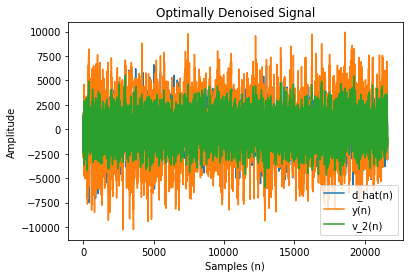

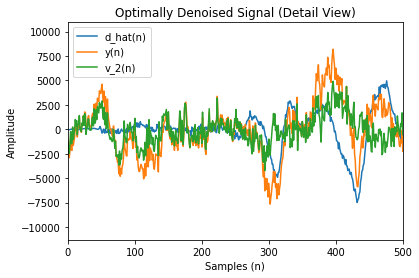

In [82]:

import time 

v_1_hat = signal.lfilter(w_hat, 1, v_2)
d_hat = y - v_1_hat


plt.plot(d_hat[:], label = "d_hat(n)")
plt.plot(y[:], label = "y(n)")
plt.plot(v_2[:], label = "v_2(n)")
plt.title("Optimally Denoised Signal") 
plt.xlabel("Samples (n)") 
plt.ylabel("Amplitude")
plt.legend()
plt.show()

plt.plot(d_hat[:], label = "d_hat(n)")
plt.plot(y[:], label = "y(n)")
plt.plot(v_2[:], label = "v_2(n)")
plt.title("Optimally Denoised Signal (Detail View)") 
plt.xlabel("Samples (n)") 
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(0, 500)
plt.show()


sd.play(d_hat.astype('int16'), 22050 )
time.sleep(2)
sd.play(y.astype('int16'), 22050 )


## Question 7
To investigate the effect of the filter order on the estimate of the audio bitstream, we will vary the filter order between $m= 2$ and $m= 20$. In you experiments, what is the minimum order necessary to remove the environmental noise? In other words, around what number does an increase in filter order no longer yield a significant improvement?  Justify your answer. **(3 points)**

### Answer 7

For our filter, one can begin to hear the noise begin to be reduced around the m = 15-17 order. At m = 20 the signal is still quite noisy. We increased the order of our filter to be around 50 , at which point we could clearly hear the gong. However, I could hear improvement in our signal even with filters with orders as high as 100.

This result is a bit surprising (considering the way this question was asked). Re aranging our for loops and multiplication operations often lead to overflows and never yielded a clear signal at m = 20. 

In theory, the Weiner filter should reach a threshold at which it is no longer effective. The size of the Weiner filter improves performance until it effectively transforms $v_2$ noise into noise $\hat{v_1}$ that has identical properties as the $v_1$ noise we wish to remove. After this good aproximation is obtained, any aditional terms added to the Weiner filter only add negligible precision to the filter. Since this $\hat{v_1}$ only has identical properties to $v_1$ and still isn't an identical signal, there will always be some nonzero error term $e$ left and therefore some noise in the system even after it is filtered 



